# **Crop Yield Prediction**

Yield Prediction for the selected crop


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/Colab Notebooks/AML_Assignment/sri_lanka_crop_data.csv'

df = pd.read_csv(filepath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory Data analysis**

In [179]:
# Basic Info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Province_Name  10000 non-null  object 
 1   District_Name  10000 non-null  object 
 2   Crop_Year      10000 non-null  int64  
 3   Season         10000 non-null  object 
 4   Crop           10000 non-null  object 
 5   Area           10000 non-null  float64
 6   Yield          9989 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 547.0+ KB
None


In [180]:
# Summary Statistics
print("\n Summary Statistics:")
print(df.describe(include="all"))



 Summary Statistics:
       Province_Name District_Name   Crop_Year Season   Crop           Area  \
count          10000         10000  10000.0000  10000  10000   10000.000000   
unique             9            25         NaN      2      9            NaN   
top          Central     Ratnapura         NaN   Maha   Rice            NaN   
freq            1152           583         NaN   5090   4334            NaN   
mean             NaN           NaN   2006.1136    NaN    NaN   24300.274136   
std              NaN           NaN      5.1528    NaN    NaN   52215.614629   
min              NaN           NaN   1997.0000    NaN    NaN       1.000000   
25%              NaN           NaN   2002.0000    NaN    NaN     500.000000   
50%              NaN           NaN   2006.0000    NaN    NaN    3724.500000   
75%              NaN           NaN   2011.0000    NaN    NaN   18579.000000   
max              NaN           NaN   2014.0000    NaN    NaN  545965.000000   

               Yield  
count 

In [181]:
# Handling Missing Values
print("\n Missing Values:")
print(df.isnull().sum())

df.dropna(inplace=True)

print("\n\n Missing Values:")
print(df.isnull().sum())


 Missing Values:
Province_Name     0
District_Name     0
Crop_Year         0
Season            0
Crop              0
Area              0
Yield            11
dtype: int64


 Missing Values:
Province_Name    0
District_Name    0
Crop_Year        0
Season           0
Crop             0
Area             0
Yield            0
dtype: int64


#Visualization of Data

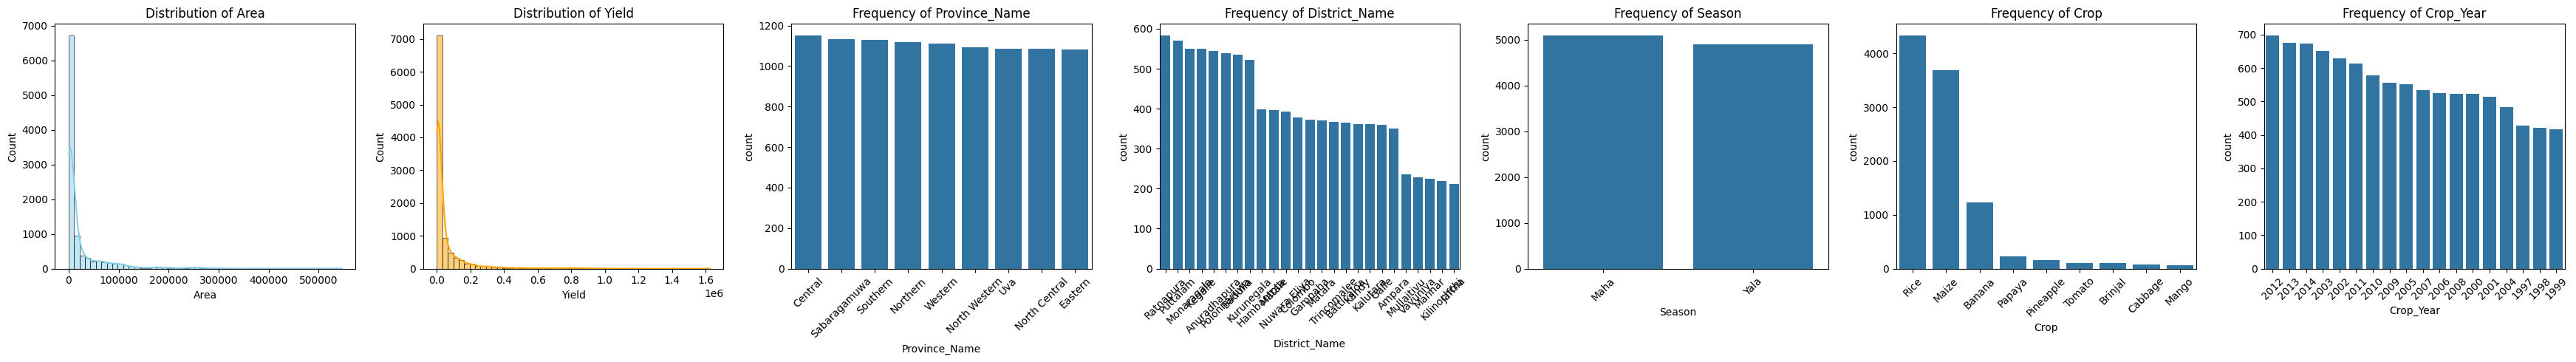

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for Area and Yield ---
plot_vars = ['Area', 'Yield']  # variables to show histograms for
num_hist = len(plot_vars)

# Identify Categorical Columns ---
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Crop_Year' in df.columns and df['Crop_Year'].dtype != 'object':
    categorical_cols.append('Crop_Year')

# Combine all plots (numerical + categorical) into one list
all_cols = plot_vars + categorical_cols
n_cols = len(all_cols)

# Set subplot dimensions
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(5 * n_cols, 5))
if n_cols == 1:
    axes = [axes]

# Plot each variable
for idx, col in enumerate(all_cols):
    ax = axes[idx]
    if col in plot_vars:
        sns.histplot(df[col], bins=50, kde=True, ax=ax, color='orange' if col == 'Yield' else 'skyblue')
        ax.set_title(f"Distribution of {col}")
    else:
        sns.countplot(x=col, data=df, order=df[col].value_counts().index, ax=ax)
        ax.set_title(f"Frequency of {col}")
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


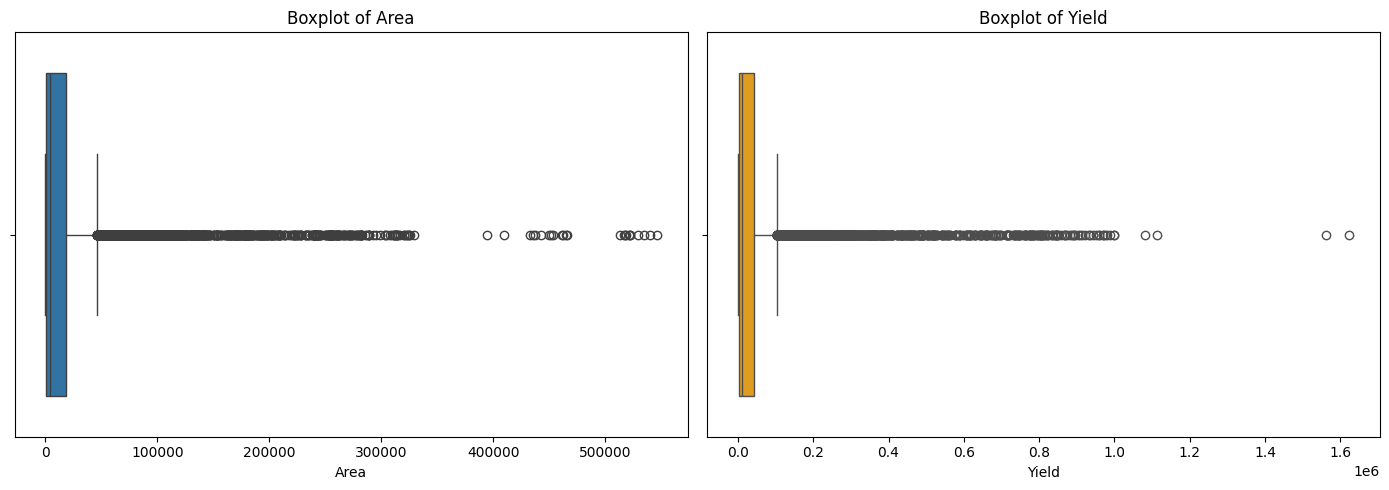

In [183]:
# Boxplots to Detect Outliers
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Area'])
plt.title("Boxplot of Area")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Yield'], color='orange')
plt.title("Boxplot of Yield")

plt.tight_layout()
plt.show()

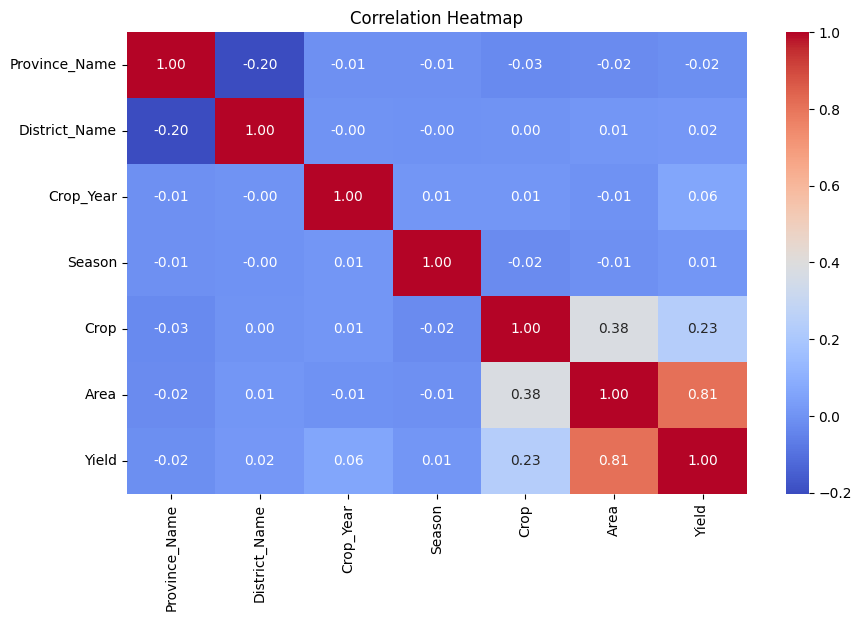

In [184]:
# Correlation Heatmap

# Encode categorical fields for correlation check
df_encoded = df.copy()
from sklearn.preprocessing import LabelEncoder
for col in ['Season', 'Crop', 'District_Name', 'Province_Name']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



*   Area vs. Yield (0.81) : larger cultivated areas generally produce higher yield.
*   Crop vs. Area (0.38) : Certain crops tend to be grown on larger land areas.
*   Yield does not depend much on season selection in this dataset
*   The Crop_Year (year of cultivation) has little impact on yield trends.
*   Province_Name and District_Name do not strongly affect crop yield, possibly because yield depends more on land area, soil, or irrigation.

# Feature Engineering

In [185]:
# Encode categorical features
le = LabelEncoder()
df['Season'] = le.fit_transform(df['Season'])
df['Crop'] = le.fit_transform(df['Crop'])
df['District_Name'] = le.fit_transform(df['District_Name'])
df['Province_Name'] = le.fit_transform(df['Province_Name'])

In [186]:
# Apply log transformation to Area and Yield
df['log_Area'] = np.log1p(df['Area'])
df['log_Yield'] = np.log1p(df['Yield'])

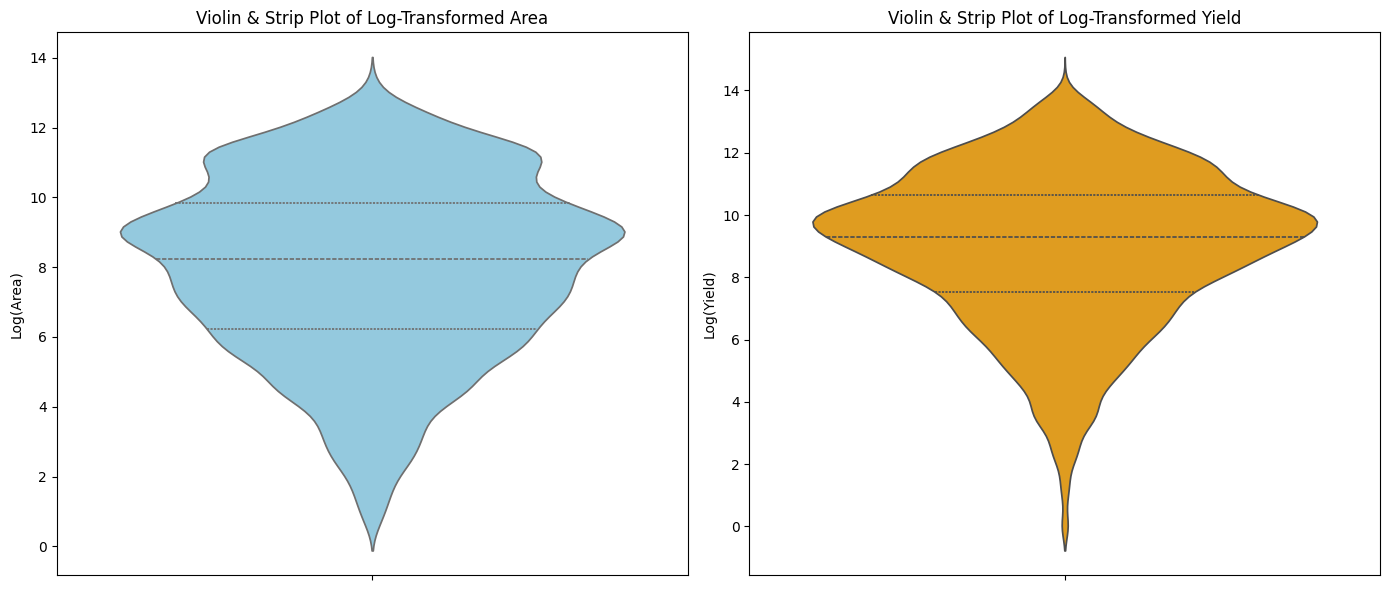

In [187]:
# Set figure size
plt.figure(figsize=(14, 6))

# Violin Plot for Log-Transformed Area
plt.subplot(1, 2, 1)
sns.violinplot(y=df['log_Area'], color='skyblue', inner="quartile")
#sns.stripplot(y=df['log_Area'], color='black', alpha=0.3, jitter=True, size=2)
plt.title("Violin & Strip Plot of Log-Transformed Area")
plt.ylabel("Log(Area)")

# Violin for Log-Transformed Yield
plt.subplot(1, 2, 2)
sns.violinplot(y=df['log_Yield'], color='orange', inner="quartile")
#sns.stripplot(y=df['log_Yield'], color='black', alpha=0.3, jitter=True, size=2)
plt.title("Violin & Strip Plot of Log-Transformed Yield")
plt.ylabel("Log(Yield)")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

*   The log transformation helped normalize the distribution, reducing skewness.
*   The dataset has a few very small and very large areas, but most values are clustered in the middle.
*   There are no extreme outliers, meaning yield predictions should be stable.


In [188]:
# Outlier removal based on IQR
Q1 = df['log_Yield'].quantile(0.25)
Q3 = df['log_Yield'].quantile(0.75)
IQR = Q3 - Q1
filtered_df = df[(df['log_Yield'] >= Q1 - 1.5 * IQR) & (df['log_Yield'] <= Q3 + 1.5 * IQR)]

# Modal Training

**Why GBR (Gradient Boosting Regressor) is the Best Choice for Crop Yield Prediction**

*   Handles Non-Linearity : Yield is influenced by multiple complex factors (e.
g., season, crop type, district).
*   Captures Feature Interactions : Boosting algorithms sequentially learn from mistakes, improving accuracy.
*   Reduces Bias & Variance : Unlike simple regression, GBR boosts weak learners and avoids overfitting.
*   Works Well with Log Transformation & Outliers : GBR learns from transformed data effectively
*   Competitive Performance vs. XGBoost & Random Forest : GBR achieves high R² (0.93+), low MAE, and stable cross-validation results.

In [189]:
features = ['Crop_Year', 'Season', 'Crop', 'log_Area', 'District_Name', 'Province_Name']
X = filtered_df[features]
y = filtered_df['log_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

# Modal Evaluation

In [190]:
# Evaluate on test set
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Calculate performance metrics
r2_train = r2_score(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
mean_cv_score = np.mean(cv_scores)

# Print performance metrics
print(f"\n🎯 Model Evaluation Metrics (Log Scale after Outlier Removal):")
print(f"Training R² Score: {r2_train:.4f}")
print(f"Testing R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cross-validation R²: {mean_cv_score:.4f}")



🎯 Model Evaluation Metrics (Log Scale after Outlier Removal):
Training R² Score: 0.9373
Testing R² Score: 0.9327
MAE: 0.4524
MSE: 0.3597
RMSE: 0.5998
Cross-validation R²: 0.8959


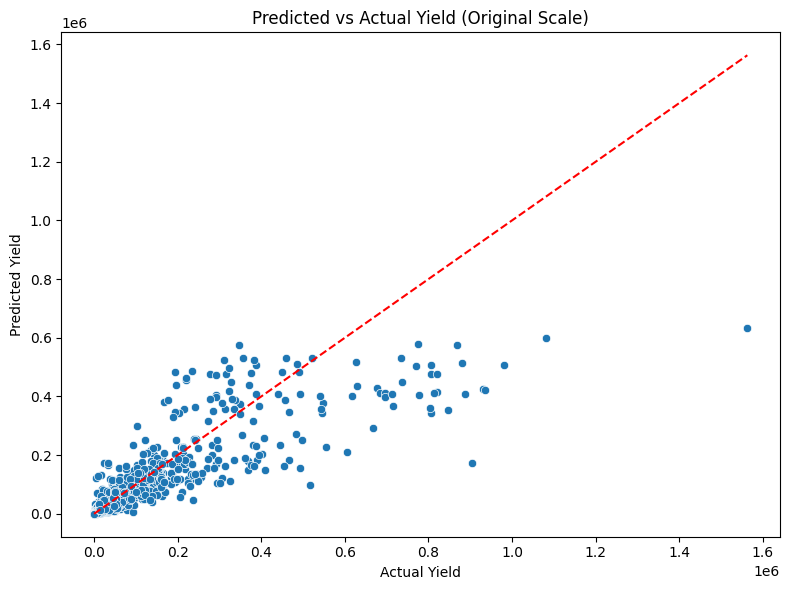

In [191]:
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_orig, y=y_pred_orig)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Original Scale)")
plt.tight_layout()
plt.show()


* Good performance for lower & mid-range yields
  * Model captures most of the general trends well.
* Predictions become less accurate for large yield values
  * Fewer training samples in the dataset for high-yield cases.
  * Higher variability in large-yield crops (e.g., different farming practices, soil conditions)

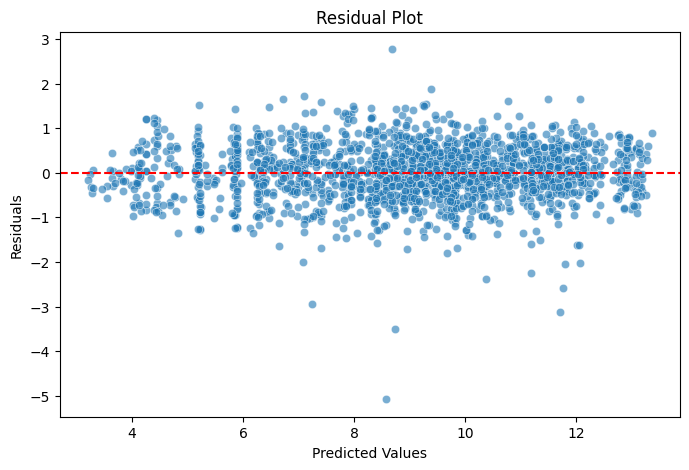

In [192]:
# Compute residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')  # Add zero reference line
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

* Residuals are randomly scattered around zero Symmetrically
  * no strong pattern or systematic error in predictions.
  * does not seem to overestimate or underestimate consistently across different yield levels.
  * indicates the model is not biased in one direction.

* Higher variance for larger predicted values and Some extreme residuals
  * the model struggles more with higher yield predictions.
  * few points have large negative residuals (below -3 to -5), meaning the model underpredicted these cases significantly and  some positive residuals (above +3) indicate overpredictions.


* Model Performance Insights
  * The model performs well overall


# SHAP Analysis

This SHAP summary plot shows how different features impact the model’s predictions for crop yield.

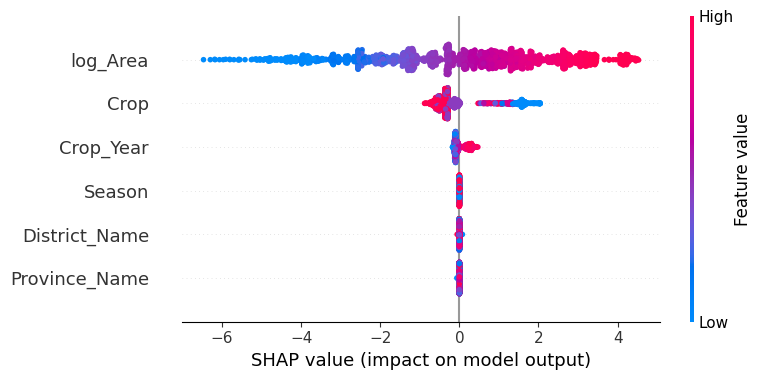

In [193]:
import shap

# TreeExplainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

* The model strongly relies on land area (log_Area) and crop type.
* Crop Year shows slight importance
* Season, District, and Province are less important

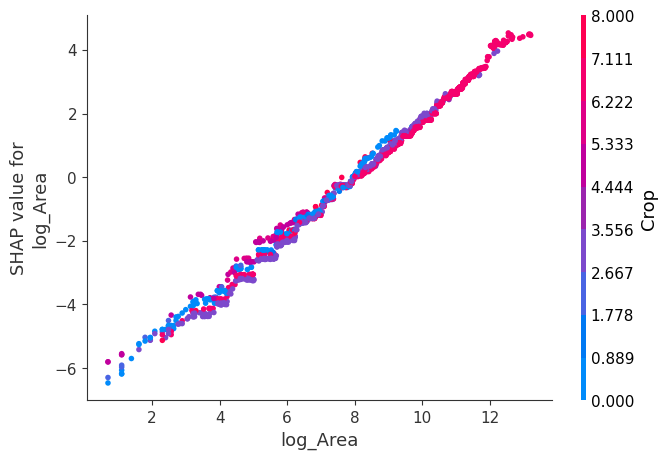

In [194]:
# Dependence Plot for Most Influential Feature (Area)
top_feature = X_test.columns[np.abs(shap_values.values).mean(0).argmax()]
shap.dependence_plot(top_feature, shap_values.values, X_test)


  * Strong Linear Relationship
  * No Sudden Jumps or Non-Linearity
  * Minimal Interaction Effect with Crop
  * The model is correctly capturing the relationship

In [195]:
# Example input data
example_input = pd.DataFrame({
    'Crop_Year': [2025],
    'Season': [2],
    'Crop': [7],
    'log_Area': [np.log1p(500)],
    'District_Name': [15],
    'Province_Name': [4]
})

# Predict using the trained model
predicted_log_yield = model.predict(example_input)

# Convert log-transformed prediction back to original scale
predicted_yield = np.expm1(predicted_log_yield)

print(f"Predicted Yield: {predicted_yield[0]:.2f}")

Predicted Yield: 1030.27
